# Low-Pass Filter

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [1]:
# import functions from modsim
import sys
sys.path.append('..\\..\\ModSimPy_Directory')
from ModSimPy_Functions.modsim import *

import pandas as pd

### Circuits, signals and filters

The following circuit diagram (from [Wikipedia](https://en.wikipedia.org/wiki/File:RC_Divider.svg)) shows a low-pass filter built with one resistor and one capacitor.  

<img src="../Images_and_Data/Images/low_pass_filter_mid.PNG" style="width: 200px;"/>

A "filter" is a circuit takes a signal, $V_{in}$, as input and produces a signal, $V_{mid}$, as output.  In this context, a "signal" is a voltage that changes over time.

A filter is "low-pass" if it allows low-frequency signals to pass from $V_{in}$ to $V_{mid}$ unchanged, but it reduces the amplitude of high-frequency signals.

By applying the laws of circuit analysis, we can derive a differential equation that describes the behavior of this system.  By solving the differential equation, we can predict the effect of this circuit on any input signal.

#### Ohm's Law

In an electric circuit, a difference in voltage is the driving force of current:  the higher voltage pushes electrons (conventionally) toward the lower voltage, in the same way that a difference in pressure drives water through a pipe.  

A resister, on the other hand, is like a blockage in the pipe: it slows the current down.  The total amount of flow (that is, current $I$) is determined by the relationship between the driving force $\Delta V$ and the resistance $R$. 

This relationship is expressed in Ohm's Law.  Suppose we are given $V_{in}$ and $V_{mid}$ at a particular instant in time.  By Ohm's law, the instantaneous current through the resistor is:

$ I_R = (V_{in} - V_{mid}) / R $

where $R$ is resistance in ohms.  

#### A capacitor circuit

The circuit shown is complicated by a capacitor $C$, which is a pair of flat plates that aren't allowed to contact one another.  When the circuit is turned on, $V_{in}$ is raised above the zero voltage at ground, which is represented by the upside down triangle.  This voltage difference causes electrons to move through the resistor.

But the electrons cannot pass across the gap between the capacitor plates: they yearn to reach the zero voltage at the ground, but cannot, and as a result, they are stored on one side of the capacitor plate.  As the plate fills with electrons, it starts to resist further flow (the electrons don't like other electrons, and so push back at new arrivals), which raises the voltage at $V_{mid}$.  When the capacitor plate is filled, $V_{mid} = V_{in}$.  There is now no voltage difference across the resistor, and the current stops. 

#### Deriving an equation for a capacitor circuit

This change in current $I$ can be represented as a differential equation:

$ I = C \frac{d V_{mid}}{dt} $

where $C$ is capacitance, or size, of the capacitor.  This equation essentially says that the current through $R$ is proportional to how quickly $V_{mid}$ is changing--if a lot of electrons are moving through $R$ onto the capacitor, then $V_{mid}$ will change quickly. 

If we sub Ohm's law ($I=\Delta V/R$) into the left hand side and rearrange, we get a differential equation for $V_{out}$:

$ \frac{d }{dt} V_{mid} = \frac{V_{in} - V_{mid}}{R C} $

How does this make a low pass filter?   If the *time constant* $RC$ is large, $\frac{d }{dt} V_{mid}$ will generally be small.  So if the input signal $V_{in}$ changes quickly, the output signal $V_{mid}$ will not be able to respond to those changes.  In effect, it will "filter out" the high frequency part of the signal.

In this chapter, we will simulate the low-pass filter for input signals of a form like this:

$ V_{in}(t) = A \cos (2 \pi f t) $

where $A$ is the amplitude of the input signal (say, 5 V), and $f$ is the frequency of the signal in Hz. 

## Params and System objects

Here's a parameter object to contain the quantities we need.  I've chosen values for `R1` and `C1` that might be typical for a circuit that works with audio signal.

In [4]:
R1 = 1.0e6   # * ohm
C1 = 1.0e-9  # * farad
A = 5.0      # * volt
f = 1000.0   # * Hz

params = R1, C1, A, f

Now we can pass the `params` object to `make_system` which computes some additional parameters and defines `init`.

* `omega` is the frequency of the input signal in radians/second.

* `tau` is the time constant for this circuit, which is roughly the time it takes to charge (i.e. fill) the capacitor.

* `cutoff` is the cutoff frequency for this circuit (in Hz), which marks the transition from low frequency signals, which pass through the filter unchanged, to high frequency signals, which are weakened.

* `t_end` is chosen so we run the simulation for 4 cycles of the input signal.

In [8]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: tuple
    
    returns: System object
    """
    R1, C1, A, f = params
    
    init = pd.Series(dict(V_mid = 0))
    # Convert frequency to radians/second
    omega = 2 * f * np.pi
    # Define the time constant tau
    tau = R1 * C1
    # Define the cutoff frequency
    cutoff = 1 / R1 / C1 / 2 / np.pi
    t_end = 4 / f
    
    return dict(R1=R1, C1=C1, A=A, f=f, 
                  init=init,
                  t_end=t_end, num=401,
                  omega=omega, tau=tau, 
                  cutoff=cutoff)

Notice that the function uses `np.pi` rather than importing `numpy` with `from numpy import pi` and then simply writing `pi`.  Either approach is acceptable.

Let's make a `System`

In [9]:
system = make_system(params)

The system variable `num` controls how many time steps we get from `run_solve_ivp`.  The default is 101; in this case we increase it to 401 because the methods we'll use to analyze the results require high resolution in time.

### Exercise 1

Write a slope function that takes as an input `t`, a `State` object that contains `V_mid`, and a `system`, and returns the derivative of `V_mid`.  You'll need to define `V_in` according to the equation in the intro.


In [10]:
# Define the slope_function

def slope_func(t, state, system):
    A, f = system['A'], system['f']
    
    V_mid = state
    V_in = A * (np.cos(2*np.pi*f*t))
        
    dVdt = (V_in - V_mid)/(system['tau'])
    
    return dVdt

Test the slope function with the initial conditions.

In [12]:
slope_func(0, system['init'], system)

V_mid    5000.0
dtype: float64

And then run the simulation. 

In [17]:
results, details = run_solve_ivp(system, slope_func)
details.message

'The solver successfully reached the end of the integration interval.'

In [18]:
results.tail()

,V_mid
0.00384,-0.591786
0.00388,-0.443763
0.00392,-0.268070
0.00396,-0.075735
0.00400,0.121274


Here's a function you can use to plot `V_mid` as a function of time.

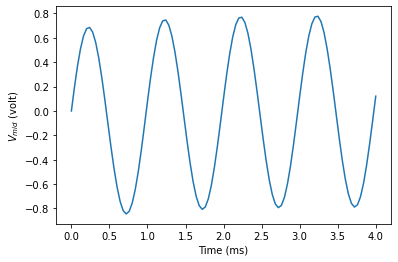

In [20]:
def plot_results(results):
    V_mid = results.V_mid.copy()
    t_end = results.index[-1]
    
    if t_end < 0.1:
        V_mid.index *= 1000
        xlabel = 'Time (ms)'
    else:
        V_mid = results.V_mid
        xlabel = 'Time (s)'
        
    V_mid.plot(label='_nolegend',xlabel=xlabel,
             ylabel='$V_{mid}$ (volt)')
    
plot_results(results)

If things have gone according to plan, the amplitude of the output signal should be about 0.8 V.

Also, you might notice that it takes a few cycles for the signal to get to the full amplitude. 

## Sweeping frequency

Here's what `V_mid` looks like for a range of frequencies:

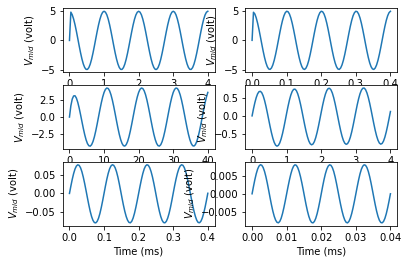

In [21]:
from matplotlib.pyplot import subplot

fs = [1, 10, 100, 1000, 10000, 100000]

for i in range(6):
    R1 = 1.0e6   
    C1 = 1.0e-9  
    A = 5.0     
    f = fs[i]   
    params = R1, C1, A, f
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func)
    subplot(3, 2, i+1)
    plot_results(results)

The low frequencies start in the upper right corner.  Notice the amplitudes, which are the same for $f = 1$ and $f = 10$.  For higher frequencies, the signal is mostly filtered out.  Notice that the cutoff frequency for this circuit (as defined in make_system above) is 159 Hz.  Do you see what that indicates here?

## Estimating the output ratio

Let's compare the amplitudes of the input and output signals.  Below the cutoff frequency, we expect them to be about the same.  Above the cutoff, we expect the amplitude of the output signal to be smaller.

We'll start with a signal at the cutoff frequency, `f=1000` Hz.

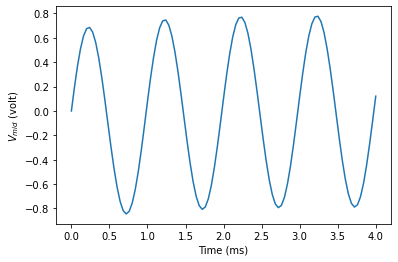

In [22]:
R1 = 1.0e6   
C1 = 1.0e-9  
A = 5.0     
f = 1000   
params = R1, C1, A, f
system = make_system(params)
results, details = run_solve_ivp(system, slope_func)
V_mid = results.V_mid
plot_results(results)

The following function computes `V_in` as a `TimeSeries`:

In [25]:
def compute_vin(results, system):
    """Computes V_in as a TimeSeries.
    
    results: TimeFrame with simulation results
    system: System object with A and omega
    
    returns: TimeSeries
    """
    A, omega = system['A'], system['omega']
    
    ts = results.index
    V_in = A * np.cos(omega * ts)
    return pd.Series(data=V_in, index=results.index, name='V_in')

Here's what the input and output look like.  Notice that the output is not just smaller; it is also "out of phase"; that is, the peaks of the output are shifted to the right, relative to the peaks of the input.

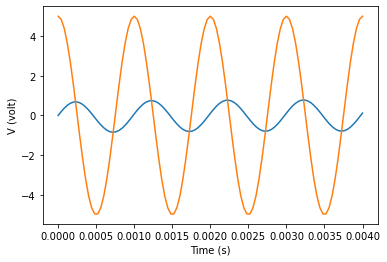

In [27]:
V_in = compute_vin(results, system)

V_mid.plot()
V_in.plot(xlabel='Time (s)',
         ylabel='V (volt)');

The following function estimates the amplitude of a signal by computing half the distance between the min and max.

In [28]:
def estimate_A(series):
    """Estimate amplitude.
    
    series: TimeSeries
    
    returns: amplitude in volts
    """
    return (series.max() - series.min()) / 2

The amplitude of `V_in` should be near 5 (but not exact because we evaluated it at a finite number of points).

In [29]:
A_in = estimate_A(V_in)
A_in

4.980286753286195

The amplitude of `V_mid` should be lower.

In [30]:
A_out = estimate_A(V_mid)
A_out

0.8112101476397462

And here's the ratio between them.

In [31]:
ratio = A_out / A_in
ratio

0.16288422491023774

### Exercise 2 

Encapsulate the code we have so far in a function that takes two `Series` objects and returns the ratio between their amplitudes.

In [32]:
# Define the function estimate_ratio
def estimate_ratio(series1,series2):
    return estimate_A(series1)/estimate_A(series2)

And test your function.

In [33]:
estimate_ratio(V_mid, V_in)

0.16288422491023774

### Exercise 3

Write a function that takes as parameters an array of input frequencies as well as the parameters for a filter.

For each input frequency it should run a simulation and use the results to estimate the output ratio (dimensionless).

It should return a `Series` object with the ratio for each input frequency.

In [34]:
# Define function sweep_frequency

def sweep_frequency(fs,params):
    sweep_output = pd.Series([],dtype=np.float64)
    R1, C1, A, f = params
    for f_var in fs:
        params =  R1, C1, A, f_var
        system = make_system(params)
        results, details = run_solve_ivp(system, slope_func)
        V_mid = results.V_mid
        V_in = compute_vin(results, system)
        sweep_output[f_var]=estimate_ratio(V_mid,V_in)
        
    return sweep_output

Run your function with these frequencies.

In [35]:
fs = 10 ** linspace(0, 4, 9)

In [37]:
R1 = 1.0e6   
C1 = 1.0e-9  
A = 5.0      
f = 1000.0  

ratios = sweep_frequency(fs, params)
pd.DataFrame(ratios)

,0
1.000000,1.000392
3.162278,1.001223
10.000000,1.000327
31.622777,0.982981
100.000000,0.849574
316.227766,0.461986
1000.000000,0.162884
3162.277660,0.050748
10000.000000,0.015944


We can plot output ratios like this:

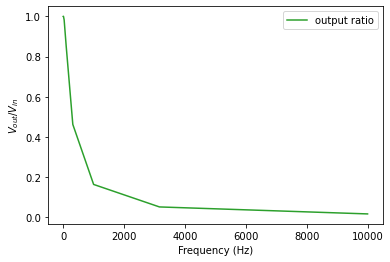

In [39]:
ratios.plot(color='C2', label='output ratio',xlabel='Frequency (Hz)',
         ylabel='$V_{out} / V_{in}$',legend=True);

But it is useful and conventional to plot ratios on a log-log scale.  The vertical gray line shows the cutoff frequency.

In [42]:
def plot_ratios(ratios, system):
    """Plot output ratios.
    """
    
    cutoff = magnitude(system['cutoff'])
    plt.axvline(cutoff, color='gray', alpha=0.4)
    
    ratios.plot(color='C2', label='output ratio',
                xlabel='Frequency (Hz)',
                ylabel='$V_{out} / V_{in}$',
                logx=True,logy=True,legend=True)

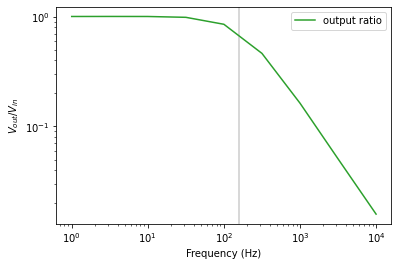

In [43]:
plot_ratios(ratios, system)

This plot shows the cutoff behavior more clearly.  To the left of the cutoff (lower frequencies), the output ratio is close to 1.  To the right of the cutoff, it drops off linearly on a log scale, which indicates that output ratios for high frequencies are practically 0.

### Exercise 4

By analysis we can show that the output ratio for this signal is

$A = \frac{1}{\sqrt{1 + (R C \omega)^2}}$ 

where $\omega = 2 \pi f$.

Write a function that takes an array of input frequencies (and parameters) and returns $A(f)$ as `SweepSeries` objects.  Plot the object and compare it with the results from the previous section.


In [46]:
# Define the function output_ratios_analy

def output_ratios_analy(fs,params):
    """Computes analytically the amplitude ratio 
    for an array of input frequencies fs.
    
    fs: Array of input frequencies
    params: parameters of the filter (R1, C1, A, f)
    
    returns: SweepSeries
    """
    R1, C1, A, f = params
    sweep_output = pd.Series([],dtype=np.float64)
    
    for f_var in fs:
        omega = 2 * np.pi * f_var
        radical = 1 + (R1 * C1 * omega)**2
        ratio = 1/np.sqrt(radical)
        sweep_output[f_var] = ratio
        
    return sweep_output

Test your function:

In [47]:
fs = 10 ** linspace(0, 4, 9)
A = output_ratios_analy(fs,params)

Plot the theoretical results along with the simulation results and see if they agree.

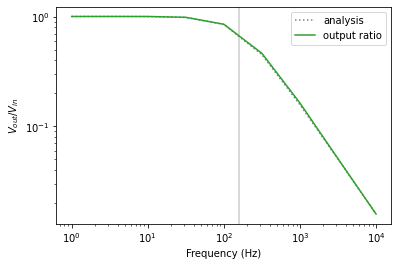

In [48]:
A.plot(style=':', color='gray', label='analysis',legend=True)
plot_ratios(ratios, system)